# Using Text From Amazon Reviews to Predict Ratings

Here we'll look at the text in a review and see if we can predict whether the review is positive (4 or 5 of 5) or negative (1, 2, or 3 of 5). We'll use Scikit Learn's NLP method Tfidf to extract features.

Note that part of this notebook has been run with previous parameters for our feature search -- ngram_range=(1,1) and min_df=5, rather than the current version of ngram_range=(1,3) and min_df=20. We'll discuss differences in the results in the conclusion, but the change did slightly improve performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

%matplotlib inline
sns.set_style('white')

In [2]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

In [3]:
raw_data = getDF('reviews_Digital_Music_5.json.gz')
raw_data.shape

(64706, 9)

In [4]:
raw_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


In [5]:
raw_data['overall'].describe()

count    64706.000000
mean         4.222514
std          1.086081
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [6]:
(raw_data['overall']<4).sum()

12590

In [7]:
# We'll set our classification threshold at 4: 4's and 5's will be positive, lower will be negative.

raw_data['outcome_var'] = np.where(raw_data['overall']<4, 0, 1)
data_clean = raw_data[['reviewText', 'outcome_var']]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [9]:
# Split the data into training and testing sets
data_train, data_test = train_test_split(data_clean, test_size=0.3, random_state=100)
print('Training and testing shapes:')
print(data_train.shape, data_test.shape)
print('Positive and negative outcome counts in training set:')
print(len(data_train[data_train['outcome_var']==1]), len(data_train[data_train['outcome_var']==0]))

# Resample the training data to increase the number of negative examples
train_pos = data_train[data_train['outcome_var']==1]
train_neg = data_train[data_train['outcome_var']==0]
train_neg = resample(train_neg, n_samples=len(train_pos))
data_train_resamp = pd.concat([train_pos, train_neg]).sample(frac=1)
print('Length of training set after resampling:')
print(len(data_train_resamp))

Training and testing shapes:
(45294, 2) (19412, 2)
Positive and negative outcome counts in training set:
36453 8841
Length of training set after resampling:
72906


In [10]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words='english',
                        ngram_range=(1, 3), 
                        analyzer='word', 
                        min_df=20,
                        max_features=None, 
                        vocabulary=None, 
                        binary=False, 
                        use_idf=True)

In [11]:
tfidf.fit(data_train_resamp.reviewText)
X_train = tfidf.transform(data_train_resamp.reviewText)
Y_train = data_train_resamp.outcome_var

X_test = tfidf.transform(data_test.reviewText)
Y_test = data_test.outcome_var

print('X_train Shape:')
print(X_train.get_shape())
print('X_test Shape:')
print(X_test.get_shape())

X_train Shape:
(72906, 52079)
X_test Shape:
(19412, 52079)


In [12]:
svd = TruncatedSVD(n_components=1000)
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)
print('SVD Shape:')
print(X_train_svd.shape)

SVD Shape:
(72906, 1000)


In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import confusion_matrix, auc, precision_recall_curve

In [13]:
def auprc(Y, Y_pred):
    precision, recall, thresholds = precision_recall_curve(Y, Y_pred)
    return auc(precision, recall)

In [62]:
# Using full dataset -- 36000 features

dtc = DecisionTreeClassifier(max_features=None, max_depth=32)
dtc.fit(X_train, Y_train)
Y_pred = dtc.predict(X_test)
print(cross_val_score(dtc, X_train, Y_train, cv=5))
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[ 0.82327527  0.8176519   0.81724043  0.82290809  0.821262  ]
[[ 2116  1633]
 [ 4105 11558]]
AUPRC: 0.105921957443


In [63]:
# Using SVD with 1000 components

dtc = DecisionTreeClassifier(max_features=None, max_depth=32)
dtc.fit(X_train_svd, Y_train)
Y_pred = dtc.predict(X_test_svd)
print(cross_val_score(dtc, X_train_svd, Y_train, cv=5))
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[ 0.8920587   0.88670964  0.8920587   0.88806584  0.89218107]
[[ 1252  2497]
 [ 2505 13158]]
AUPRC: 0.0979335051142


In [60]:
dtc_params = {'max_depth':[4, 8, 16, 32],
              'max_features':[4, 10, 'sqrt', None],
              'min_samples_split':[2, 8, 32]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dtc_params)
dtc_grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 8, 16, 32], 'max_features': [4, 10, 'sqrt', None], 'min_samples_split': [2, 8, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [61]:
print(dtc_grid.best_score_)
print(dtc_grid.best_params_)

0.813938496146
{'max_depth': 32, 'max_features': None, 'min_samples_split': 2}


In [14]:
rfc = RandomForestClassifier(n_estimators=64, max_depth=32, min_samples_split=8)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[[ 2280  1469]
 [ 1876 13787]]
AUPRC: 0.133417239986


In [65]:
rfc_params = {'max_depth':[4, 8, 16, 32],
              'n_estimators':[8, 16, 32, 64],
              'min_samples_split':[2, 8, 32]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid=rfc_params)
rfc_grid.fit(X_train_svd, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 8, 16, 32], 'n_estimators': [8, 16, 32, 64], 'min_samples_split': [2, 8, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best params for RFC are: max_depth=32, min_samples_split=8, n_estimators=64. With this we're getting an AUPRC of 0.132. Confusion matrix is: 

[[ 2129  1620]

[ 1600 14063]]

So at least our true negatives are greater than false negatives or false positives! Better than most of our models...

In [66]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

0.963158039119
{'max_depth': 32, 'min_samples_split': 8, 'n_estimators': 64}


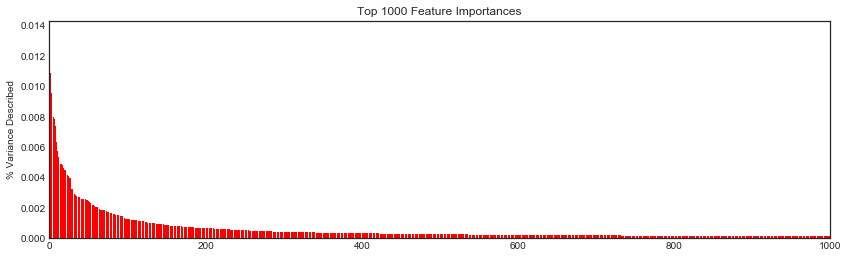

In [15]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:1000]

# Plot the feature importances of the forest
plt.figure(figsize=(14, 4))
plt.title("Top {} Feature Importances".format(len(top_indices)))
plt.bar(range(len(top_indices)), importances[top_indices],
       color="r", align="center")
plt.xlim([-1, len(top_indices)])
plt.ylabel('% Variance Described')
plt.show()

In [17]:
for n_idx in [100, 200, 500, 1000, 2000, 5000, 10000, 20000]:
    print('Variance explained with {} features: {}'.format(n_idx, importances[indices[:n_idx]].sum()))
print('Total Features: ' + str(len(indices)))

Variance explained with 100 features: 0.3211160692062343
Variance explained with 200 features: 0.4126542795724461
Variance explained with 500 features: 0.5341381243188429
Variance explained with 1000 features: 0.6284265258986561
Variance explained with 2000 features: 0.7243891957777864
Variance explained with 5000 features: 0.8450331053479401
Variance explained with 10000 features: 0.9349523739086338
Variance explained with 20000 features: 0.9988838145768447
Total Features: 52079


Feature importance appears to drop off dramatically after the first 500 features, but the tail is long enough that lower importances still play a large role in the variance of the model. But remember -- we started with 52,000 features, so even dropping down to 5,000 is a significant reduction. All features after 20,000 have essentially zero importance.

In [18]:
n_indices = 5000
X_train_rfc = X_train[:, indices[:n_indices]]
X_test_rfc = X_test[:, indices[:n_indices]]
print(X_train_rfc.shape, X_test_rfc.shape)

n_indices = 20000
X_train_full = X_train[:, indices[:n_indices]]
X_test_full = X_test[:, indices[:n_indices]]
print(X_train_full.shape, X_test_full.shape)

(72906, 5000) (19412, 5000)
(72906, 20000) (19412, 20000)


In [54]:
rfc = RandomForestClassifier(n_estimators=64, max_depth=32, min_samples_split=8)
rfc.fit(X_train_rfc, Y_train)
Y_pred = rfc.predict(X_test_rfc)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[[ 2148  1601]
 [ 1751 13912]]
AUPRC: 0.130730987486


In [70]:
lgr = LogisticRegression(penalty='l2', C=.65, fit_intercept=True)
lgr.fit(X_train, Y_train)
print(cross_val_score(lgr, X_train, Y_train, cv=5))
Y_pred = lgr.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[ 0.86174736  0.86737073  0.86236456  0.86591221  0.86769547]
[[ 2797   952]
 [ 2157 13506]]
AUPRC: 0.146906889434


Even with all that RFC tuning, logistic regression runs better than random forest.

In [ ]:
# Beware -- slow to run. Use fewer features.
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train_rfc, Y_train)
Y_pred = knc.predict(X_test_rfc)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

In [19]:
bnb = BernoulliNB()
bnb.fit(X_train, Y_train)
Y_pred = bnb.predict(X_test)
print(cross_val_score(bnb, X_train, Y_train, cv=5))
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[ 0.77842546  0.77287066  0.7826087   0.78196159  0.78744856]
[[ 2809   940]
 [ 4666 10997]]
AUPRC: 0.124988222709


In [24]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[[ 356   16]
 [1899  808]]
AUPRC: 0.0687317577271


In [20]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=4)
gbc.fit(X_train_full, Y_train)
Y_pred = gbc.predict(X_test_full)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[[ 2724  1025]
 [ 3683 11980]]
AUPRC: 0.131013974112


In [24]:
gbc_params = {'max_depth':[12, 24],
              'n_estimators':[50, 100],
              'learning_rate':[0.1, 0.3]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_params, scoring='average_precision')
gbc_grid.fit(X_train_rfc, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [12, 24], 'n_estimators': [50, 100], 'learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [23]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

0.937523619882
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50}


In [14]:
rfc = RandomForestClassifier(n_estimators=64, max_depth=32, min_samples_split=8)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[[ 2280  1469]
 [ 1876 13787]]
AUPRC: 0.133417239986


In [20]:
rfc.score(X_test, Y_test)

0.82768390686173499

In [21]:
lgr = LogisticRegression(penalty='l2', C=.65, fit_intercept=True)
lgr.fit(X_train, Y_train)
print(cross_val_score(lgr, X_train, Y_train, cv=5))
Y_pred = lgr.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print('AUPRC: ' + str(auprc(Y_test, Y_pred)))

[ 0.88108627  0.88142916  0.88108627  0.88408779  0.87969822]
[[ 2772   977]
 [ 1949 13714]]
AUPRC: 0.147860529058


In [22]:
lgr.score(X_test, Y_test)

0.84926849371522772

## Conclusion

Well, we're doing okay, maybe even pretty good. The accuracy of our model is slightly better than guessing only the more common class (acc = 0.85), however, we have a lot of false positives and false negatives. It turns out logistic regression actually performed best, slightly beating out random forest and gradient boosting, both of which are significantly slower to run. 

Initially, we ran the feature creation using ngram_range=(1,1), which only selects one-word phrases, and min_df=5, which means we'll use them even if they're fairly rare in the data set. I switched the parameters to ngram_range=(1,3) and min_df=20, which means we'll use up to 3-word phrases, but they have to be slightly more common in the data set to make the cut. This brought our raw feature set from 36,000 to 52,000, and slightly increased our accuracy. I may be able to increase performance even more by reducing min_df, but that would also inflate our feature set and slow down processing. A project for a faster machine. 

Other notable bits from our modeling: KNN took forever to run, I suspect because of the large number of features. SVC did terribly. I wonder if logistic regression did better than random forest because of the large feature set as well. There are so many possible choices a decision tree could be making that it can only choose the few that are most effective. Regression, on the other hand, fits every feature quickly. 

I used one of the smaller sets of Amazon reviews to go easy on my processor, but I suspect we could do even better on a larger set (this one had 64,000 points).